In [1]:
import utils
from regions.selectivesearch_answer import selective_search
# from regions.selectivesearch import selective_search

# from nms import non_max_supression_slow as nms
from nms import non_max_supression_with_scores as nms

import chainer
from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

%matplotlib inline 

In [2]:
##############
# PARAMETERS #
##############

# DIRECTORY
DIR = '/data/unagi0/ilsvrc2017/ILSVRC/'

# GPU (-1 if performing on CPU)
GPU = -1

# IMAGE SELECTION PARAMETERS
# RANDOM_SEED = 200
# NUMBER_OF_IMAGES = 3
RANDOM_SEED = 111
# RANDOM_SEED = 206
# RANDOM_SEED = 188
NUMBER_OF_IMAGES = 1

# SELECTIVE-SEARCH PARAMETERS
SS_PARAMS = {"SCALE": 250,
            "SIGMA": 0.9,
            "MIN_SIZE": 50,
            "MIN_REGION": 2000,
            "MAX_RATIO": 2}

# NMS PARAMETERS
OVERLAP_THRESHOLD = 0.3

# DISPLAY DETECTED REGIONS WITH CONFIDENCE ABOVE
CONF_THRESHOLD = 0.3

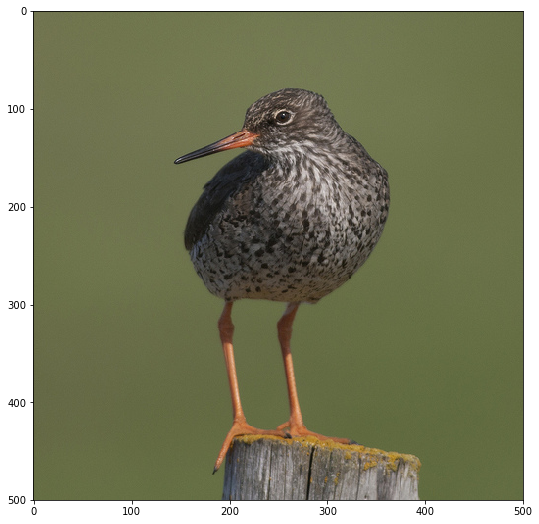

In [3]:
# Get image filenames from val.txt image set
# image_paths = utils.random_image_set(RANDOM_SEED, DIR, NUMBER_OF_IMAGES)

# local Images
image_paths = ['./test_images/ILSVRC2012_val_00033333.JPEG',
               './test_images/ILSVRC2012_val_00022529.JPEG',
             './test_images/ILSVRC2013_val_00000663.JPEG',
             './test_images/ILSVRC2012_val_00020569.JPEG',
             './test_images/ILSVRC2012_val_00042005.JPEG']

image_paths = image_paths[:NUMBER_OF_IMAGES]

# Load and Display images
imgs = utils.get_images(image_paths, display=True)

# Each image in imgs is intialized as a dictionary:
# imgs.append({"original": img,
#               "cropped_regions": [],
#               "bboxes": [],
#               "classes": [],
#               "confidences": [],
#               "area": area})

CPU times: user 1.42 s, sys: 52.8 ms, total: 1.47 s
Wall time: 1.47 s


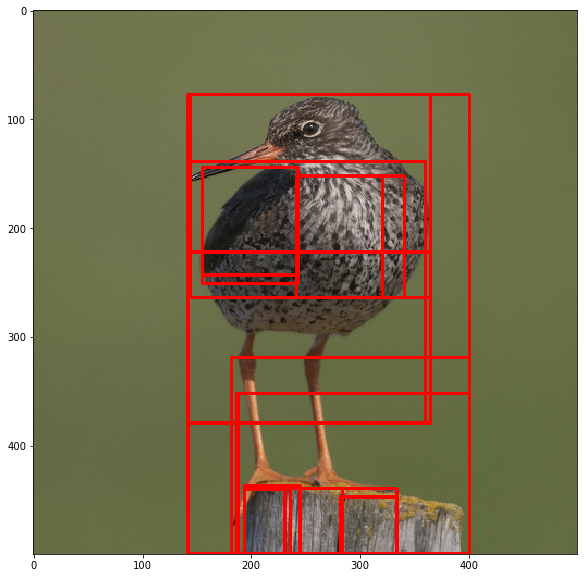

In [4]:
%%time
# Performs selective search using function "selective_search"
# perform_selectivesearch appends bboxes to img["bboxes"] and cropped regions to img["cropped_regions"]
utils.perform_selectivesearch(selective_search, imgs, SS_PARAMS)

In [5]:
# Initialize VGG16 classifier model
extractor = VGG16(1000, 'imagenet')
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')
if GPU >= 0:
    chainer.cuda.get_device(GPU).use()
    model.to_gpu()

In [6]:
%%time
# perform_classification appends class predictions to img["classes"] and confidences to img["confidences"]
utils.perform_classification(model, imgs)

CPU times: user 9.52 s, sys: 655 ms, total: 10.2 s
Wall time: 1.19 s


In [7]:
%%time
# Perform non maximum supression on bounding boxes. For regions havin an overlap exceeding the threshold
# The region with the lower confidence score will be suppressed
for img in imgs:
    img["selected_regions"] = nms(img["bboxes"], img["confidences"], OVERLAP_THRESHOLD)

CPU times: user 1.28 ms, sys: 367 µs, total: 1.65 ms
Wall time: 1.66 ms


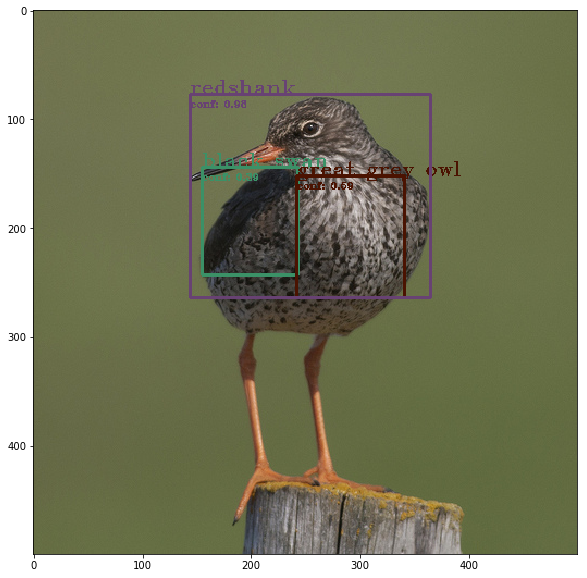

In [14]:
# Display Detected Regions and Classes
utils.display_detections(imgs, CONF_THRESHOLD)